# Gaussian Mixture Model (GMM) Clustering

We cluster customers using GMM with four features:
- Age
- Annual Income (k$)
- Spending Score (1-100)

We will:
- Scale features
- Fit GMM across k = 2..10
- Evaluate with Silhouette + BIC/AIC
- Visualize PCA scatter + Silhouette plot
- Summarize cluster profiles


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # avoid Windows + MKL init warning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples

np.random.seed(42)

# folder to store visuals
FIG_DIR = Path("./reports/figs")
FIG_DIR.mkdir(parents = True, exist_ok = True)

# Load and Preprocess Data

We load the customer dataset and rename columns. 
We use four features: Age, Annual Income, and Spending Score.

In [3]:
# Load Mall Customers csv
csv_path = "./Mall_Customers.csv"
df = pd.read_csv(csv_path)

# Dataset uses 'Genre' for gender ... my OCD can't handle that
# so we rename it and other columns here
df = df.rename(columns={
    "Genre" : "Gender",
    "Annual Income (k$)" : "Annual Income",
    "Spending Score (1-100)" : "Spending Score"
})

cols = ["Age", "Annual Income", "Spending Score"]
X = df[cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features:", cols)
print("Shape after scaling:", X_scaled.shape)

Features: ['Age', 'Annual Income', 'Spending Score']
Shape after scaling: (200, 3)


# Model Selection

We fit GMMs for k = 2-10 and evaluate with:
- **Silhouette Score** (higher = better separation)
- **BIC/AIC** (lower = better model fit)

In [4]:
K = list(range(2, 11))
sil_scores, bics, aics = [], [], []

for k in K:
    gmm = GaussianMixture(
        n_components = k, 
        covariance_type = "full", 
        random_state = 42, 
        reg_covar = 1e-6, 
        init_params = "kmeans"
    )

    gmm.fit(X_scaled)
    labels_k = gmm.predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels_k))
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

best_k_sil = K[int(np.argmax(sil_scores))]
best_k_bic = K[int(np.argmin(bics))]
best_k_aic = K[int(np.argmin(aics))]

print("k vs silhouette:", list(zip(K, [round(s, 3) for s in sil_scores])))
print("Best k (Silhouette):", best_k_sil)
print("Best k (BIC/AIC):", best_k_bic, "/", best_k_aic)

k vs silhouette: [(2, 0.329), (3, 0.335), (4, 0.373), (5, 0.376), (6, 0.4), (7, 0.394), (8, 0.343), (9, 0.34), (10, 0.305)]
Best k (Silhouette): 6
Best k (BIC/AIC): 4 / 9


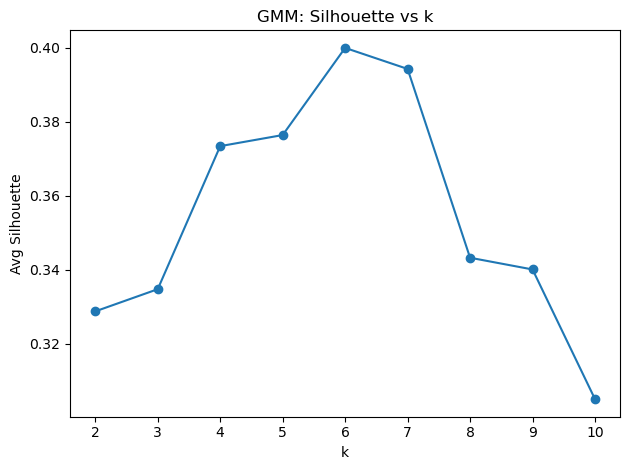

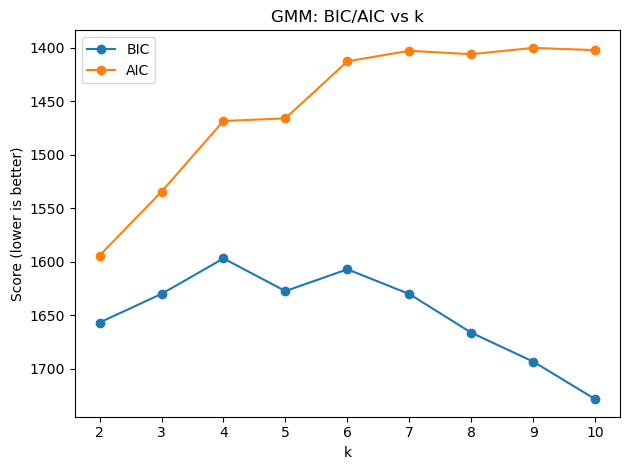

In [5]:
plt.figure()
plt.plot(K, sil_scores, marker = "o")
plt.xlabel("k"); plt.ylabel("Avg Silhouette")
plt.title("GMM: Silhouette vs k")
plt.tight_layout()
plt.savefig(FIG_DIR / "gmm_silhouette_vs_k.png", dpi = 150)

plt.figure()
plt.plot(K, bics, marker = "o", label = "BIC")
plt.plot(K, aics, marker = "o", label = "AIC")
plt.gca().invert_yaxis() # Lower is better
plt.xlabel("k"); plt.ylabel("Score (lower is better)")
plt.title("GMM: BIC/AIC vs k")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "gmm_bic_aic_vs_k.png", dpi= 150)
plt.show()

## Fit Final Model
We select k from Silhouette and re-fit the model.

In [6]:
FINAL_K = best_k_sil
gmm = GaussianMixture(
    n_components = FINAL_K, 
    covariance_type = "full", 
    random_state = 42, 
    reg_covar = 1e-6, 
    init_params = "kmeans"
).fit(X_scaled)

labels = gmm.predict(X_scaled)
df["Cluster"] = labels
final_sil = silhouette_score(X_scaled, labels)

print(f"Final k = {FINAL_K}, silhouette = {final_sil:.3f}")
print("Cluster sizes:\n", df["Cluster"].value_counts().sort_index())
print("Mixing proportions:", np.round(gmm.weights_, 3))
print("Means (scaled):\n", np.round(gmm.means_, 3))

Final k = 6, silhouette = 0.400
Cluster sizes:
 Cluster
0    53
1    39
2    18
3    37
4    30
5    23
Name: count, dtype: int64
Mixing proportions: [0.267 0.197 0.086 0.181 0.15  0.118]
Means (scaled):
 [[ 0.968 -0.184 -0.046]
 [-0.442  0.978  1.228]
 [-1.037 -1.393  1.216]
 [-1.052 -0.229 -0.086]
 [ 0.383  1.135 -1.26 ]
 [ 0.434 -1.292 -1.104]]


## PCA Visualization
We reduce the features to 2D with PCA and plot clusters.

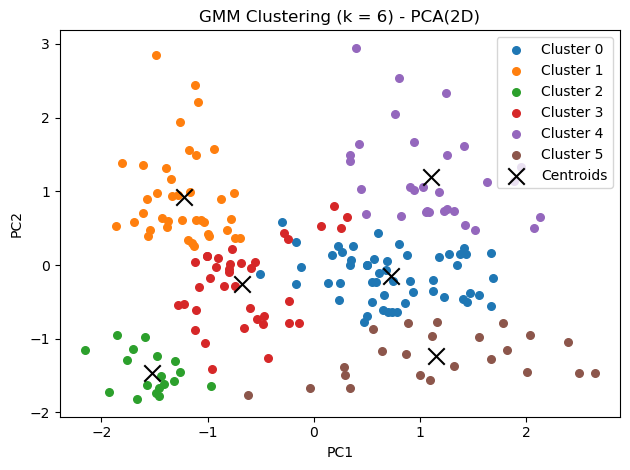

In [7]:
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X_scaled)
means_pca = pca.transform(gmm.means_)

plt.figure()
for c in range(FINAL_K):
    plt.scatter(
        X_pca[labels == c, 0], 
        X_pca[labels == c, 1], 
        s = 30, 
        label = f"Cluster {c}"
    )

plt.scatter(
    means_pca[:, 0], 
    means_pca[:, 1], 
    marker = "x", 
    s = 140, 
    c = "black", 
    label = "Centroids"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"GMM Clustering (k = {FINAL_K}) - PCA(2D)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "gmm_pca_scatter.png", dpi = 150)
plt.show()

# Silhouette Plot

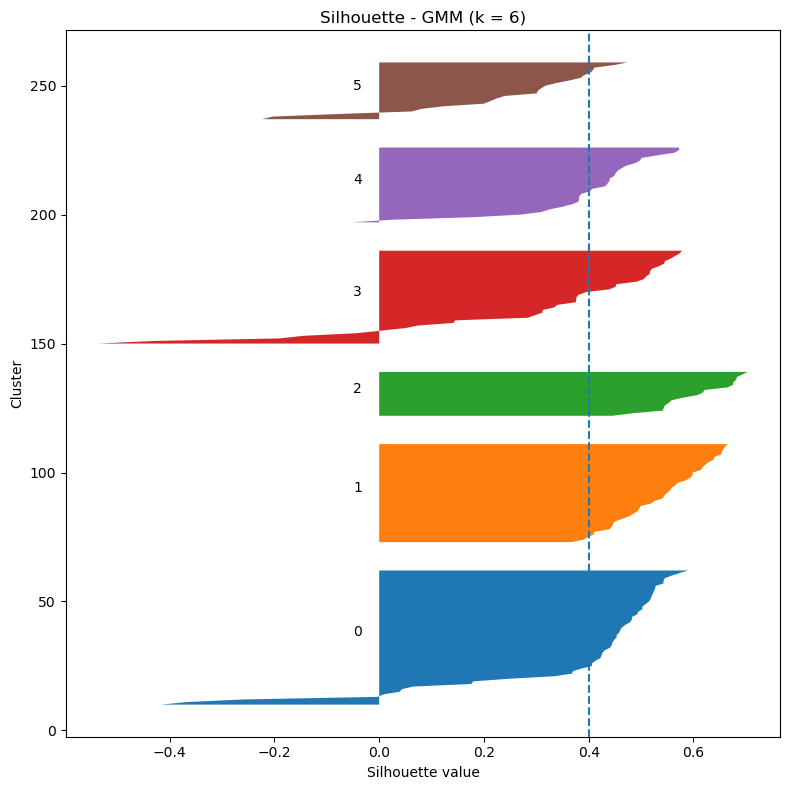

In [8]:
svals = silhouette_samples(X_scaled, labels)
y = 10
plt.figure(figsize = (8, 8))
for c in range(FINAL_K):
    s_c = np.sort(svals[labels == c])
    n_c = len(s_c)
    plt.fill_betweenx(np.arange(y, y + n_c), 0, s_c)
    plt.text(-0.05, y + n_c/2, str(c))
    y += n_c + 10

plt.axvline(np.mean(svals), linestyle = "--")
plt.xlabel("Silhouette value"); plt.ylabel("Cluster")
plt.title(f"Silhouette - GMM (k = {FINAL_K})")
plt.tight_layout(); plt.savefig(FIG_DIR / "gmm_silhouette_plot.png", dpi = 150)
plt.show()

# Cluster Profiles
We summarize Age, Income, and Spending per cluster.

In [9]:
profiles = df.groupby("Cluster").agg({
    "Age": ["mean", "median", "min", "max", "std", "count"],
    "Annual Income": ["mean", "median", "min", "max", "std"],
    "Spending Score": ["mean", "median", "min", "max", "std"]
}).round(2)

#profiles.rename(columns={"mean" : "Male Share"}, level = 1, inplace = True)
profiles

Age                             Annual Income                  \
          mean median min max    std count          mean median min  max   
Cluster                                                                    
0        52.55   50.0  28  70  10.91    53         55.81   54.0  40   76   
1        32.69   32.0  27  40   3.73    39         86.54   79.0  69  137   
2        24.22   23.0  18  35   4.91    18         24.44   22.0  15   38   
3        24.35   24.0  18  35   5.01    37         54.65   57.0  25   81   
4        44.43   44.0  32  59   8.37    30         90.40   87.0  71  137   
5        45.22   46.0  19  67  13.23    23         26.30   25.0  15   39   

               Spending Score                        
           std           mean median min max    std  
Cluster                                              
0         8.60          49.02   48.0  35  60   6.40  
1        16.31          82.13   83.0  63  97   9.36  
2         7.37          81.89   80.0  66  99   9.63  
3        13.92          47.19   51.0   5  73  16.58  
4        16.67          17.93   16.5   1  39   9.89  
5         7.89          20.91   17.0   3  40  13.02

# Cluster Interpretation

Now that we’ve grouped customers with GMM, the next step is to figure out what these groups mean.  
We’ll look at the average income, spending score, and age in each cluster and then give each group a simple label, like “Premium Customers” or “Careful Customers.”  

This makes the clusters easier to understand and helps connect the results to real-world business insights.

In [11]:
income_low, income_high = np.quantile(df["Annual Income"], [0.33, 0.66])
spend_low, spend_high   = np.quantile(df["Spending Score"], [0.33, 0.66])

# Per-cluster summary
gmm_summary = (
    df.groupby("Cluster")
      .agg(Count=("Cluster", "size"),
           AvgIncome=("Annual Income", "mean"),
           AvgSpending=("Spending Score", "mean"),
           AvgAge=("Age", "mean"))

      .round({"AvgIncome": 1, "AvgSpending": 1, "AvgAge": 1})
      .sort_index()
)

def label_cluster(inc, spend):
    if inc < income_low and spend < spend_low:
        return "Low Income, Low Spending (Careful Customers)"
    if inc < income_low and spend >= spend_high:
        return "Low Income, High Spending (Impulsive Customers)"
    if inc >= income_high and spend < spend_low:
        return "High Income, Low Spending (Conservative Wealthy Customers)"
    if inc >= income_high and spend >= spend_high:
        return "High Income, High Spending (Premium Customers)"
    if inc < income_low and spend_low <= spend < spend_high:
        return "Low Income, Medium Spending (Occasional Shoppers)"
    if income_low <= inc < income_high and spend < spend_low:
        return "Medium Income, Low Spending (Price-Sensitive)"
    if income_low <= inc < income_high and spend >= spend_high:
        return "Medium Income, High Spending (Enthusiastic Buyers)"
    return "Medium Income, Medium Spending (Standard Customers)"

# Build the readable output
print("Cluster Interpretation:")
print("=" * 50)
for cid, row in gmm_summary.iterrows():
    inc = row["AvgIncome"]
    spd = row["AvgSpending"]
    cnt = int(row["Count"])
    interpretation = label_cluster(inc, spd)
    print(f"\nCluster {cid} ({cnt} customers):")
    print(f"  Average Income: ${inc:.1f}k")
    print(f"  Average Spending Score: {spd:.1f}")
    print(f"  Average Age: {row['AvgAge']:.1f}")
    print(f"  Interpretation: {interpretation}")

Cluster Interpretation:

Cluster 0 (53 customers):
  Average Income: $55.8k
  Average Spending Score: 49.0
  Average Age: 52.5
  Interpretation: Medium Income, Medium Spending (Standard Customers)

Cluster 1 (39 customers):
  Average Income: $86.5k
  Average Spending Score: 82.1
  Average Age: 32.7
  Interpretation: High Income, High Spending (Premium Customers)

Cluster 2 (18 customers):
  Average Income: $24.4k
  Average Spending Score: 81.9
  Average Age: 24.2
  Interpretation: Low Income, High Spending (Impulsive Customers)

Cluster 3 (37 customers):
  Average Income: $54.6k
  Average Spending Score: 47.2
  Average Age: 24.4
  Interpretation: Medium Income, Medium Spending (Standard Customers)

Cluster 4 (30 customers):
  Average Income: $90.4k
  Average Spending Score: 17.9
  Average Age: 44.4
  Interpretation: High Income, Low Spending (Conservative Wealthy Customers)

Cluster 5 (23 customers):
  Average Income: $26.3k
  Average Spending Score: 20.9
  Average Age: 45.2
  Interpre